In [4]:
# Importing all necessary modules
import pandas as pd
import numpy as np
import string
import re
import multiprocessing
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords
nltk.download("stopwords")

# Set Seaborn style and color palette
sns.set(rc={'axes.facecolor': 'cornflowerblue', 'figure.facecolor': 'cornflowerblue'})

# Ignore warnings

warnings.filterwarnings("ignore")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [6]:
# Importing the data
full_data = pd.read_csv("training.1600000.processed.noemoticon.csv", 
                        encoding="ISO-8859-1", 
                        names=["target", "ids", "date", "flag", "user", "text"])

# Display the first few rows of the dataset
full_data.head()

# Calculate the maximum length of text entries
max_len = max(len(x) for x in full_data['text'])
max_len

374

In [7]:
# Taking a sample of 200,000 entries from the dataset
data = full_data.sample(200000, random_state=42)

In [8]:
# Generating descriptive statistics for the dataset, including all columns
data.describe(include="all")

,target,ids,date,flag,user,text
count,200000.000000,2.000000e+05,200000,200000,200000,200000
unique,NaN,NaN,175012,1,148283,199166
top,NaN,NaN,Mon Jun 01 11:08:39 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,7,200000,72,31
mean,2.002860,1.999372e+09,NaN,NaN,NaN,NaN
std,2.000003,1.933568e+08,NaN,NaN,NaN,NaN
min,0.000000,1.467813e+09,NaN,NaN,NaN,NaN
25%,0.000000,1.957136e+09,NaN,NaN,NaN,NaN
50%,4.000000,2.002150e+09,NaN,NaN,NaN,NaN
75%,4.000000,2.177196e+09,NaN,NaN,NaN,NaN


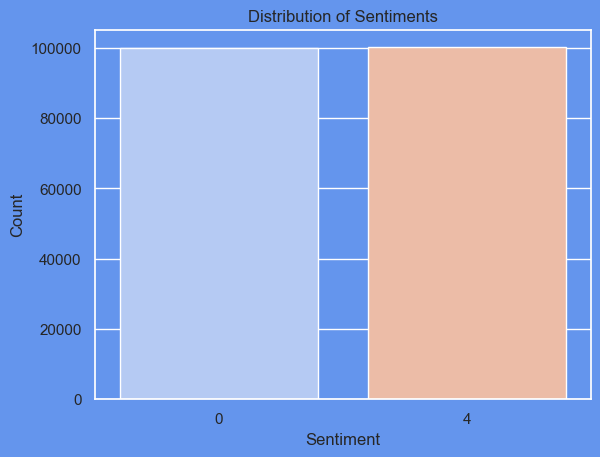

In [10]:
# Plotting the distribution of the target variable with a custom color scheme
sns.countplot(x=data['target'], palette='coolwarm')

# Adding a title and labels to the plot
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# This shows that the data is equally distributed between positive and negative sentiments.

In [11]:
# Dropping columns that cannot be used for analysis
data = data.drop(['ids', 'date', 'flag', 'user'], axis=1)

In [12]:
# Converting the target variable to binary classification
data['target'] = data['target'].replace(4, 1)

# Here, 4 represents positive sentiment. Converting it to 1 for binary classification.

In [13]:
# Splitting the data into features (X) and target (y)
X = data["text"]
y = data["target"].values

In [14]:
# Displaying the first line of the feature data
first_line = X.iloc[1]
print(first_line)

# This is the first line of our data.

@misstoriblack cool , i have no tweet apps  for my razr 2


In [15]:
# Defining functions used for cleaning the data

def text_splitting(text):
    """Splits text into words based on white spaces."""
    return text.split()

def lower_case(words):
    """Converts all words to lower case for uniformity."""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Removes punctuation marks from the words."""
    reg_punc = re.compile('[%s]' % re.escape(string.punctuation))  # Regex to remove punctuations
    return [reg_punc.sub('', w) for w in words]

def only_alphabets(words):
    """Keeps only alphabetic words, removing digits."""
    return [word for word in words if word.isalpha()]

def remove_stopwords(words):
    """Removes stop words like 'and', 'of', 'is', etc."""
    stop_words = set(stopwords.words('english'))
    return [w for w in words if w not in stop_words]

def to_sentence(words):
    """Joins split words back into a sentence."""
    return ' '.join(words)

def remove_noise(text):
    """Cleans text by applying all the preprocessing steps."""
    words = text_splitting(text)
    words = lower_case(words)
    words = remove_punctuation(words)
    words = only_alphabets(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [16]:
# Applying all cleaning functions to the features
X_cleaned = X.apply(remove_noise)

# Displaying the first few rows of the cleaned data
X_cleaned.head()

541200                           chrishasboobs ahhh hope ok
750                      misstoriblack cool tweet apps razr
766711    tiannachaos know family drama lamehey next tim...
285055    school email wont open geography stuff revise ...
705995                                upper airways problem
Name: text, dtype: object

In [17]:
# Splitting the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X_cleaned, y, test_size=0.20, random_state=272, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=272, stratify=y_temp)

In [18]:
# Creating tokens for training the model
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Calculating the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

116482

In [19]:
# Determining the longest text in the training, validation, and testing data for model parameters
maxlen_train = max(len(x) for x in X_train)
maxlen_test = max(len(x) for x in X_test)
maxlen_val = max(len(x) for x in X_val)

# Display the longest text lengths
print("Maximum length in training data:", maxlen_train)
print("Maximum length in testing data:", maxlen_test)
print("Maximum length in validation data:", maxlen_val)

# Displaying the first few rows of the training data
X_train.head()

Maximum length in training data: 140
Maximum length in testing data: 127
Maximum length in validation data: 131


864108    joepolitics im sure well celebrating hard plus...
541193    djsouthanbred oh thats whats babeno havent yea...
363137    lmfaoooo illmaticp came barbiebanga sorry laug...
124021    still raining windy come wife goes mountain bi...
127109                                           college xx
Name: text, dtype: object

In [20]:
# Creating sequences for training, validation, and testing data
training_sequence = tokenizer.texts_to_sequences(X_train)
training_sequence_padded = pad_sequences(training_sequence, maxlen=maxlen_train, padding='post', truncating='post')

test_sequence = tokenizer.texts_to_sequences(X_test)
test_sequence_padded = pad_sequences(test_sequence, maxlen=maxlen_train, padding='post', truncating='post')

val_sequence = tokenizer.texts_to_sequences(X_val)
val_sequence_padded = pad_sequences(val_sequence, maxlen=maxlen_train, padding='post', truncating='post')

In [21]:
# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size + 1, output_dim=32, input_length=maxlen_train),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Compiling the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [22]:
# Displaying the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 32)           3727456   
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1

In [23]:
# Training the model
history = model.fit(
    training_sequence_padded, y_train,
    validation_data=(val_sequence_padded, y_val),
    epochs=10,
    batch_size=32,  # Added batch size for better performance
    verbose=1       # Added verbosity to show training progress
)

Epoch 1/10
4000/4000 [==============================] - 71s 17ms/step - loss: 0.5455 - accuracy: 0.7272 - val_loss: 0.6012 - val_accuracy: 0.6731
Epoch 2/10
4000/4000 [==============================] - 68s 17ms/step - loss: 0.4666 - accuracy: 0.7806 - val_loss: 0.4780 - val_accuracy: 0.7679
Epoch 3/10
4000/4000 [==============================] - 69s 17ms/step - loss: 0.4288 - accuracy: 0.8015 - val_loss: 0.4873 - val_accuracy: 0.7658
Epoch 4/10
4000/4000 [==============================] - 69s 17ms/step - loss: 0.3925 - accuracy: 0.8203 - val_loss: 0.5215 - val_accuracy: 0.7689
Epoch 5/10
4000/4000 [==============================] - 70s 17ms/step - loss: 0.3599 - accuracy: 0.8351 - val_loss: 0.5145 - val_accuracy: 0.7624
Epoch 6/10
4000/4000 [==============================] - 70s 17ms/step - loss: 0.3313 - accuracy: 0.8509 - val_loss: 0.5720 - val_accuracy: 0.7567
Epoch 7/10
4000/4000 [==============================] - 70s 17ms/step - loss: 0.3063 - accuracy: 0.8621 - val_loss: 0.5819 -

1250/1250 [==============================] - 4s 3ms/step - loss: 0.6931 - accuracy: 0.7431
Accuracy on testing set = 0.7430750131607056


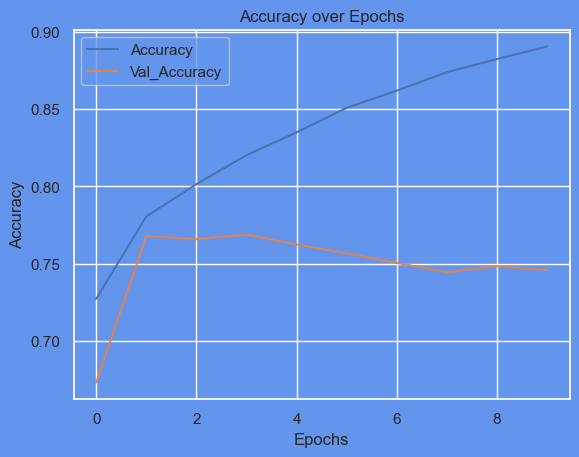

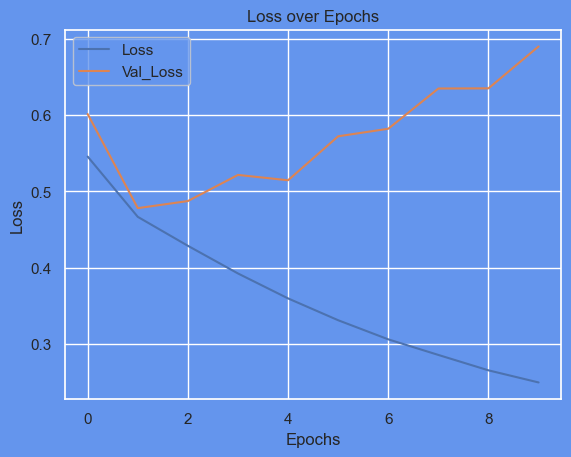

In [24]:
# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_sequence_padded, y_test)
print("Accuracy on testing set =", accuracy)

# Function to plot accuracy and loss graphs
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend([metric.capitalize(), 'Val_' + metric.capitalize()])
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")